# Projeto 1
## Introdução a Data Science
### Alunos
Gabriel de Melo Evangelista (gme@cin.ufpe.br)

Maria Luísa Leandro de Lima (mlll@cin.ufpe.br)
### Tema: Powerlifting
https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

### Imports

In [95]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Leitura dos dados limpos 

In [96]:
df = pd.read_csv('../powerlifting_clean.csv')

Com intuitos de classificação, a coluna BodyweightKg_dist será definida como categórica.

In [97]:
df['Bodyweight_dist'] = df['BodyweightKg_dist'].astype('category')

In [98]:
df.dtypes

Name                   object
Sex                     int64
Event                  object
Equipment              object
Division               object
BodyweightKg          float64
WeightClassKg          object
Best3SquatKg          float64
Best3BenchKg          float64
Best3DeadliftKg       float64
TotalKg               float64
Place                   int64
Dots                  float64
Wilks                 float64
Glossbrenner          float64
Goodlift              float64
EquipmentC              int64
DivisionC               int64
WeightClassKgC          int64
PlaceC                  int64
NameC                   int64
Age                   float64
Age_log               float64
BodyweightKg_log      float64
total_bodyweight      float64
BodyweightKg_dist      object
Age_dist               object
Bodyweight_dist      category
dtype: object

### 1. Escolha da Coluna

Como expresso no outro notebook, a coluna BodyweightKg_dist será utilizada para classificação.

In [99]:
X = df[['Sex', 'Division', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg', 'TotalKg', 'PlaceC', 'Age']]
y = df['Bodyweight_dist']

In [100]:
X.dtypes

Sex                  int64
Division            object
Best3SquatKg       float64
Best3BenchKg       float64
Best3DeadliftKg    float64
TotalKg            float64
PlaceC               int64
Age                float64
dtype: object

Como é possível observar a coluna Division é do tipo objeto, é necessário transformá-la em código.

In [101]:
X['Division'] = X['Division'].astype('category').cat.codes

/tmp/ipykernel_26185/348644553.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Division'] = X['Division'].astype('category').cat.codes


As features utilizadas são colocadas na matriz X enquanto que a coluna a ser prevista é colocada no y.

In [102]:
len(y.value_counts())

5

### 2. Entendimento dos dados

In [103]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
data = PCA(n_components = 2).fit_transform(X_scaled)

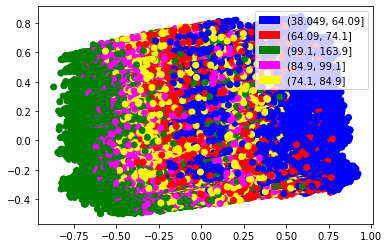

In [105]:
color_label = {'(38.049, 64.09]': 'blue', '(64.09, 74.1]': 'red', '(99.1, 163.9]': 'green', '(84.9, 99.1]': 'magenta', '(74.1, 84.9]': 'yellow'}

label_color = [color_label[x] for x in y]
import matplotlib.patches as mpatches


plt.scatter(data[:, 0], data[:, 1], c=label_color)
team_patches = [mpatches.Patch(color=color, label=team) for team, color in color_label.items()]
plt.legend(handles=team_patches, loc='upper right')
plt.show()

In [106]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=len(y.value_counts()))
kmeans.fit(data)

KMeans(n_clusters=5)

<Figure size 720x504 with 0 Axes>

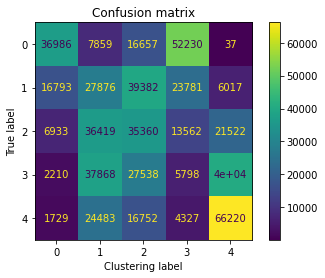

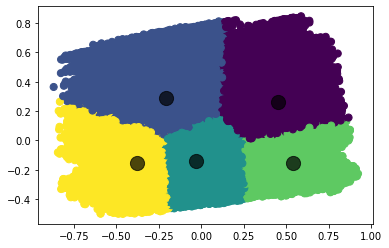

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y.cat.codes, kmeans.labels_)

plt.figure(figsize = (10,7))
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7)


### 3. Separação dos dados

Para realizar a separação dos dados será utilizada a função "train_test_split" do sklearn.

Os dados serão separados em 50% para treino, 25% para validação e 25% para teste. Para isso, será utilizada a função 2 vezes como observado abaixo.

In [108]:
X_train, x_f, y_train, y_f = train_test_split(X, y, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(x_f, y_f, test_size = 0.5)

In [109]:
X.shape

(568810, 8)

In [110]:
X_train.shape

(284405, 8)

In [111]:
X_val.shape

(142202, 8)

In [112]:
X_test.shape

(142203, 8)

Percebe-se pelos prints acima que a divisão funcionou da forma esperada.

### 4. Seleção dos algoritmos

In [113]:

from sklearn.ensemble import RandomForestClassifier
tree = RandomForestClassifier().fit(X_train, y_train)

In [114]:
y_pred = tree.predict(X_val)

In [115]:
accuracy_score(y_pred, y_val)

0.48491582396872057